In [ ]:
# Kaggle brain tumor Image Classification (MRI) - Kaggle 뇌종양(Brain Tumor) 이미지 분류

# Brain Tumor Classification(MRI) 데이터는 뇌종양(Brain Tumor)을 발견하고 구체적으로 어떤 뇌종양인지 예측하기 위한
# Kaggle의 공개 데이터로서, 평균적으로 512x512 크기를 가지는 총 3,160개의 이미지 데이터
# glioma - 신경교종(glioma tumor)
# meningioma - 수막종 (Meningioma)
# notumor - 종양 없음 (No tumor)
# pituitary - 뇌하수체 종양 (pituitary tumor)

# MobileNet(pre-trained model) -> GlobalAveragePooling(Flatten Layer) -> relu -> relu -> softmax
# 학습데이터 개수가 3,000개 정도로서 매우 부족하기 때문에 Transfer Learning 사용함 - pre-trained model(mobilenet_v2)

In [3]:
# 라이브러리
import os
import shutil
import random
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

# GPU 설정
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('pytorch version : ', torch.__version__, ', device : ', DEVICE)

pytorch version :  2.7.1+cu118 , device :  cuda


In [5]:
# ===============================
# 데이터 경로 설정
# ===============================
ROOT_DIR = '.\\data'
DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'brain_tumor')
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'Training')
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'Testing')

In [6]:
# 데이터 폴더 존재시 삭제
if os.path.exists('.\\data\\brain_tumor'):
    shutil.rmtree('.\\data\\brain_tumor')
    print('.\\data\\brain_tumor is removed')

.\data\brain_tumor is removed


In [7]:
# 압축 해제
with zipfile.ZipFile(os.path.join(ROOT_DIR, 'brain_tumor.zip'), 'r') as target_file:
    target_file.extractall(DATA_ROOT_DIR)

In [ ]:
# 데이터 재구축 - Testing 데이터 -> Training 데이터
# - Testing 데이터와 Training 데이터가 이질적이기 때문에 학습 정확도와 테스트 정확도의 편차를 줄여서 모델의 신뢰성을 높이기 위함
# 1) 학습 전에 Testing 데이터와 Training 데이터를 혼합하고
# 2) Training : Testing = 8 : 2 비율로 데이터를 재구축

test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

for label_name in test_label_name_list: # Testing 디렉토리 각각의 label(정답)
    test_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)
    # print(test_path)
    test_file_list = os.listdir(test_path) # label 디렉토리에 있는 이미지 파일 목록을 뽑아냄
    # print(test_file_list)
    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    # print(train_path)
    moved_num = 0

    for test_image_file in test_file_list: # 모든 이미지 파일
        # Testing 디렉토리 이미지 파일을 동일한 label의 Training 디렉토리로 이동
        shutil.move(os.path.join(test_path, test_image_file),
                    os.path.join(train_path, test_image_file))
        
        moved_num = moved_num + 1
    
    print(str(moved_num) + ' is moved into ' + label_name + ' (Testing => Training)')

['glioma', 'meningioma', 'notumor', 'pituitary']
300 is moved into glioma (Testing => Training)
306 is moved into meningioma (Testing => Training)
405 is moved into notumor (Testing => Training)
300 is moved into pituitary (Testing => Training)


In [16]:
# 데이터 재구축 - Training 데이터 -> Testing 데이터

MOVE_RATIO = 0.2 # train : test = 80 : 20, 즉 train 데이터 20% 데이터를 test 데이터로 사용

label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(label_name_list)

for label_name in label_name_list: # Training 디렉토리 각각의 label(정답)
    # 파일 move 하기 위한 src_dir_path, dst_dir_path 설정
    src_dir_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    dst_dir_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)

    train_data_file_list = os.listdir(src_dir_path) # label 디렉토리에 있는 이미지 파일 목록을 뽑아냄
    random.shuffle(train_data_file_list)
    # print(train_data_file_list)

    # 데이터 다양성을 위해 train data를 random하게 shuffle 한 후에, test data list 생성
    split_num = int(MOVE_RATIO * len(train_data_file_list))
    test_data_file_list = train_data_file_list[0:split_num]

    # shutil.move 이용해서 Training 디렉토리에서 20% 비율로 test data를 생성해서 Testing 디렉토리로 이동
    for test_data_file in test_data_file_list:
        try:
            shutil.move(os.path.join(src_dir_path, test_data_file),
                        os.path.join(dst_dir_path, test_data_file))
        except Exception as err:
            print(str(err))

['glioma', 'meningioma', 'notumor', 'pituitary']


In [17]:
# ===============================
# Dataset 준비
# ===============================
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32

# transforms 설정
train_transforms = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet 기준 정규화
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# datasets.ImageFolder
train_dataset = datasets.ImageFolder(TRAIN_DATA_ROOT_DIR, transform=train_transforms)
test_dataset = datasets.ImageFolder(TEST_DATA_ROOT_DIR, transform=test_transforms)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 정답 label
class_names = train_dataset.classes
print('클래스 : ', class_names)

클래스 :  ['glioma', 'meningioma', 'notumor', 'pituitary']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4308496].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9254032].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3611329].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2042704].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Cli

torch.Size([32, 3, 224, 224]) torch.Size([32])
{0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}


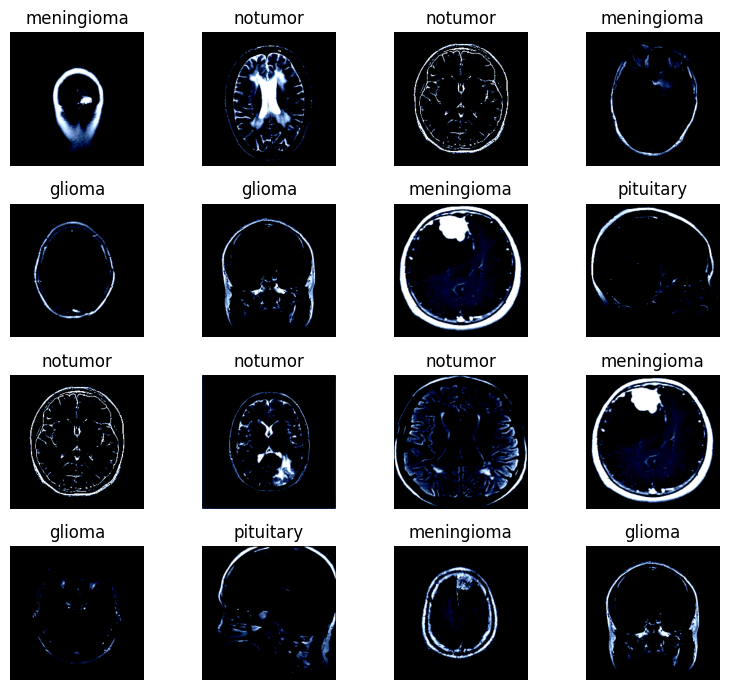

In [19]:
# 1개 배치 추출
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

# labels map 생성
labels_map = { v : k for k, v in train_dataset.class_to_idx.items() }
print(labels_map)

# 이미지 시각화
plt.figure(figsize=(8, 7))
cols, rows = 4, 4

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1, )).item()
    img, label = images[sample_idx], labels[sample_idx].item()
    plt.subplot(rows, cols, i)
    plt.imshow(torch.permute(img, (1, 2, 0)))
    plt.title(labels_map[label])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [20]:
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1) # pre-trained model 다운로드
print(model)
print('------------------------------')
print(model.last_channel)
print('------------------------------')
print(model.classifier[1].in_features)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [21]:
# ===============================
# 모델 정의 (MobileNetV2)
# ===============================
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1) # pre-trained model 다운로드

# nn.Sequential() 구조로 설계
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.last_channel, 512), # 마지막 입력값(in_features=1280)을 가져오는 코드 - model.last_channel or model.classifier[1].in_features
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Linear(128, len(class_names)),
    nn.Softmax(dim=1)
)

model = model.to(DEVICE)

In [22]:
# ===============================
# 손실함수 & 옵티마이저
# ===============================
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

In [23]:
# ===============================
# 학습 함수
# ===============================
def train_model(model, loss_function, optimizer, train_loader, val_loader, num_epochs=50, patience=5):
    best_loss = np.inf
    counter = 0
    train_acc_hist, val_acc_hist = [], []
    train_loss_hist, val_loss_hist = [], []

    for epoch in range(num_epochs):
        # --- Train ---
        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad() # 미분 초기화
            outputs = model(inputs) # 모델 예측
            loss = loss_function(outputs, labels) # 손실함수 계산

            _, preds = torch.max(outputs, 1) # 예측값 분리
            loss.backward() # 미분 연산
            optimizer.step() # 미분 연산 후 파라미터(가중치, 바이어스) 업데이트

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset) # 평균 손실함수값
        epoch_acc = running_corrects.double() / len(train_loader.dataset) # 평균 정확도값
        train_loss_hist.append(epoch_loss)
        train_acc_hist.append(epoch_acc.item())

        # --- Validation ---
        model.eval()
        val_running_loss, val_running_corrects = 0.0, 0

        with torch.no_grad(): # 오차역전파 사용 안함, 미분 연산 하지 않음
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs) # 모델 예측
                loss = loss_function(outputs, labels) # 손실함수값 계산

                _, preds = torch.max(outputs, 1) # 예측값 분리
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

        val_loss = val_running_loss / len(val_loader.dataset) # validation 평균 손실함수값
        val_acc = val_running_corrects.double() / len(val_loader.dataset) # validation 평균 정확도값
        val_loss_hist.append(val_loss)
        val_acc_hist.append(val_acc.item())

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f} "
              f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f}")

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered")
                model.load_state_dict(best_model_wts)
                break

    return model, (train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist)

In [24]:
# ===============================
# 학습 실행
# ===============================
model, history = train_model(model, loss_function, optimizer, train_loader, test_loader, num_epochs=50)

Epoch 1/50 - Train loss: 1.2341, acc: 0.5590 Val loss: 0.9949, acc: 0.7607
Epoch 2/50 - Train loss: 0.9335, acc: 0.8357 Val loss: 0.8234, acc: 0.9288
Epoch 3/50 - Train loss: 0.8188, acc: 0.9374 Val loss: 0.7919, acc: 0.9530
Epoch 4/50 - Train loss: 0.7913, acc: 0.9594 Val loss: 0.7831, acc: 0.9601
Epoch 5/50 - Train loss: 0.7770, acc: 0.9721 Val loss: 0.7776, acc: 0.9658
Epoch 6/50 - Train loss: 0.7682, acc: 0.9797 Val loss: 0.7713, acc: 0.9715
Epoch 7/50 - Train loss: 0.7638, acc: 0.9820 Val loss: 0.7695, acc: 0.9736
Epoch 8/50 - Train loss: 0.7627, acc: 0.9829 Val loss: 0.7695, acc: 0.9751
Epoch 9/50 - Train loss: 0.7566, acc: 0.9893 Val loss: 0.7661, acc: 0.9758
Epoch 10/50 - Train loss: 0.7546, acc: 0.9902 Val loss: 0.7660, acc: 0.9779
Epoch 11/50 - Train loss: 0.7548, acc: 0.9904 Val loss: 0.7641, acc: 0.9793
Epoch 12/50 - Train loss: 0.7516, acc: 0.9936 Val loss: 0.7621, acc: 0.9808
Epoch 13/50 - Train loss: 0.7521, acc: 0.9927 Val loss: 0.7654, acc: 0.9779
Epoch 14/50 - Train l

In [25]:
# Save the model checkpoint
torch.save(model.state_dict(), '.\\models\\model_transfer_learning_brain_tumor_mri.ckpt')

In [26]:
# ===============================
# 테스트 성능 평가
# ===============================
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 98.36%


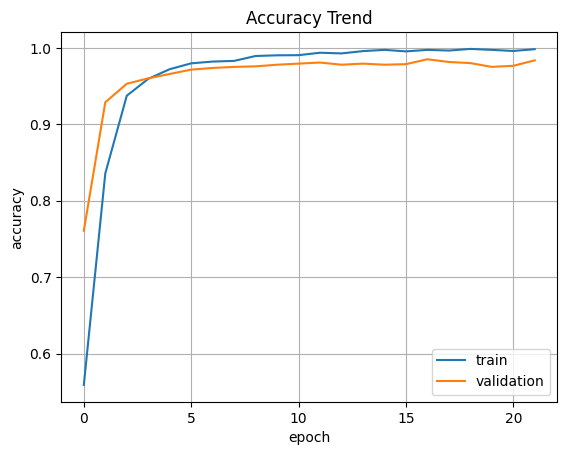

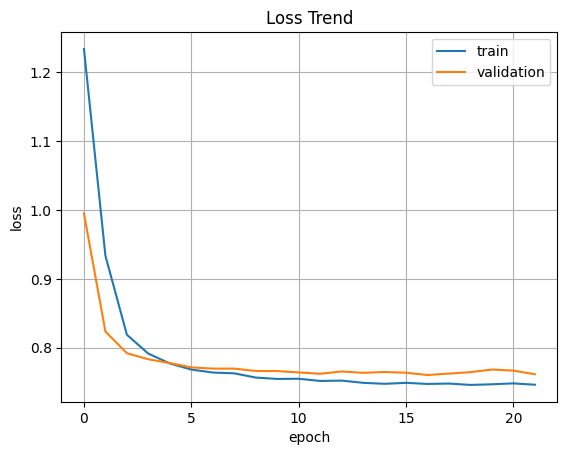

In [27]:
# ===============================
# 성능 시각화
# ===============================
train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist = history

plt.plot(train_acc_hist, label='train')
plt.plot(val_acc_hist, label='validation')
plt.title('Accuracy Trend')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.show()

plt.plot(train_loss_hist, label='train')
plt.plot(val_loss_hist, label='validation')
plt.title('Loss Trend')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()